In [27]:
# 1. Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Install mlxtend if needed
try:
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS
except ModuleNotFoundError:
    !pip install mlxtend
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [28]:
# %% [code] - Data Preprocessing
# Load original data
original_df = pd.read_excel(r'C:\Project\livertransplant\datasets\GRWR _0.8.xlsx', sheet_name='Sheet1')

# Print EXACT column names with hidden characters
print("Original Columns (Exact Names):")
print([repr(col) for col in original_df.columns])

# Create working copy with renamed column
working_df = original_df.copy(deep=True)

# Define column names
exact_long_col = 'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'


# Create working copy with guaranteed rename
working_df = original_df.copy()
working_df.rename(columns={exact_long_col: 'Diagnosis_Code'}, inplace=True)

# Validate rename
assert 'Diagnosis_Code' in working_df.columns, "Rename failed! Check exact_long_col"
print("\nWorking Copy Columns:", working_df.columns.tolist())

# Clean columns in working copy
columns_to_drop = [
    'Tx No', 'Name', 'UHID', 'Adult  = 0; ped = 1 ',
    'Portal vein thrombosis', 'Preoperative HCC',
    'date of surgery', 'additional procedures',
    'Post op Ascites N=0; Y = 1', 'Post op Day 1 bili',
    'post op Day 7 bili', 'INR on day 7', 'Grade3/4 encephalopathy N=0/Y=1',
    'Early graft dysfunction N =0/Y=1', 'HAT', 'PVT',
    'Biliary complications', 'Post op AKI N= 0; Y = 1',
    'Post op sepsis N=0; Y = 1', 'Rexploration N= 0 ; Y = 1',
    'Length of hospital stay', 'Alive/Dead 0 = 0; D=1',
    'in-hospital mortality Y=1, N=0', 'Date of death',
    'Highest clavein dindo score', 'Length of Followup',
    'Other postop complication', 'Cause of death',
    'Additional comments'
 
]
# Ensure no hidden spaces in column names
working_df.columns = working_df.columns.str.strip()

# Drop unwanted columns
working_df = working_df.drop(columns_to_drop, axis=1, errors='ignore')

# Validate if drop worked
print("Remaining Columns after dropping unwanted ones:", working_df.columns.tolist())

# Handle missing values
categorical_cols = working_df.select_dtypes(include=['object']).columns
numerical_cols = working_df.select_dtypes(include=['number']).columns

# Fill categorical columns with mode
for col in categorical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].mode()[0])

# Fill numerical columns with median
for col in numerical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].median())

# Handle missing values
working_df['SFSS Y=1/N=0'] = working_df['SFSS Y=1/N=0'].fillna(0).astype(int)
working_df = working_df.apply(pd.to_numeric, errors='coerce')
working_df = working_df.dropna(axis=1, how='all')
working_df = working_df.fillna(working_df.median())


Original Columns (Exact Names):
["'Tx No'", "'Name'", "'UHID'", "'Age'", "'Gender M = 0; F = 1'", "'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'", "'BMI '", "'MELD/PELD'", "'Adult  = 0; ped = 1 '", "'Portal vein thrombosis'", "'Preoperative HCC'", "'date of surgery'", "'Donor Age'", "'Donor Gender M = 0; F=1'", "'Lobe - RL=0, RPS = 1, LL = 2'", "'additional procedures'", "'Graft wt '", "'GRWR'", "'Blood loss'", "'CIT'", "'WIT'", "'Portal velocity'", "'Pre-reperfusion portal pressure'", "'Post- reperfusion portal pressure'",

In [29]:
# %% [code] - Model Training
X = working_df.drop('SFSS Y=1/N=0', axis=1)
y = working_df['SFSS Y=1/N=0']
feature_names = X.columns.tolist()  # Now contains SHORT_COL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("After SMOTE, class distribution in training set:")
print(pd.Series(y_train_res).value_counts())

After SMOTE, class distribution in training set:
SFSS Y=1/N=0
0    140
1    140
Name: count, dtype: int64


In [30]:
# %% [code] - Feature Selection and Visualization
def plot_features(df, title, xlabel='Importance', palette='viridis'):
    plt.figure(figsize=(16, 10))
    sns.barplot(x=xlabel, y='Feature', data=df.head(15), palette=palette)
    plt.title(f'Top 15 Features - {title}', fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

Random Forest Feature Importances (Table):
                              Feature  Importance
15  Post- reperfusion portal pressure    0.155897
2                      Diagnosis_Code    0.146414
6                           Donor Age    0.102545
11                         Blood loss    0.084601
12                                CIT    0.059383
9                            Graft wt    0.056220
14                    Portal velocity    0.055702
3                                 BMI    0.045142
13                                WIT    0.041762
10                               GRWR    0.037543
4                           MELD/PELD    0.035918
0                                 Age    0.031820
18                   LRV , N=0, Y = 1    0.031261
16               PM 0/1 N0 = 0, Y = 1    0.026316
7             Donor Gender M = 0; F=1    0.025382
17                   SAL N = 0, Y = 1    0.017537
24                 Change in velocity    0.012818
22            Post PM Portal velocity    0.011412
23     

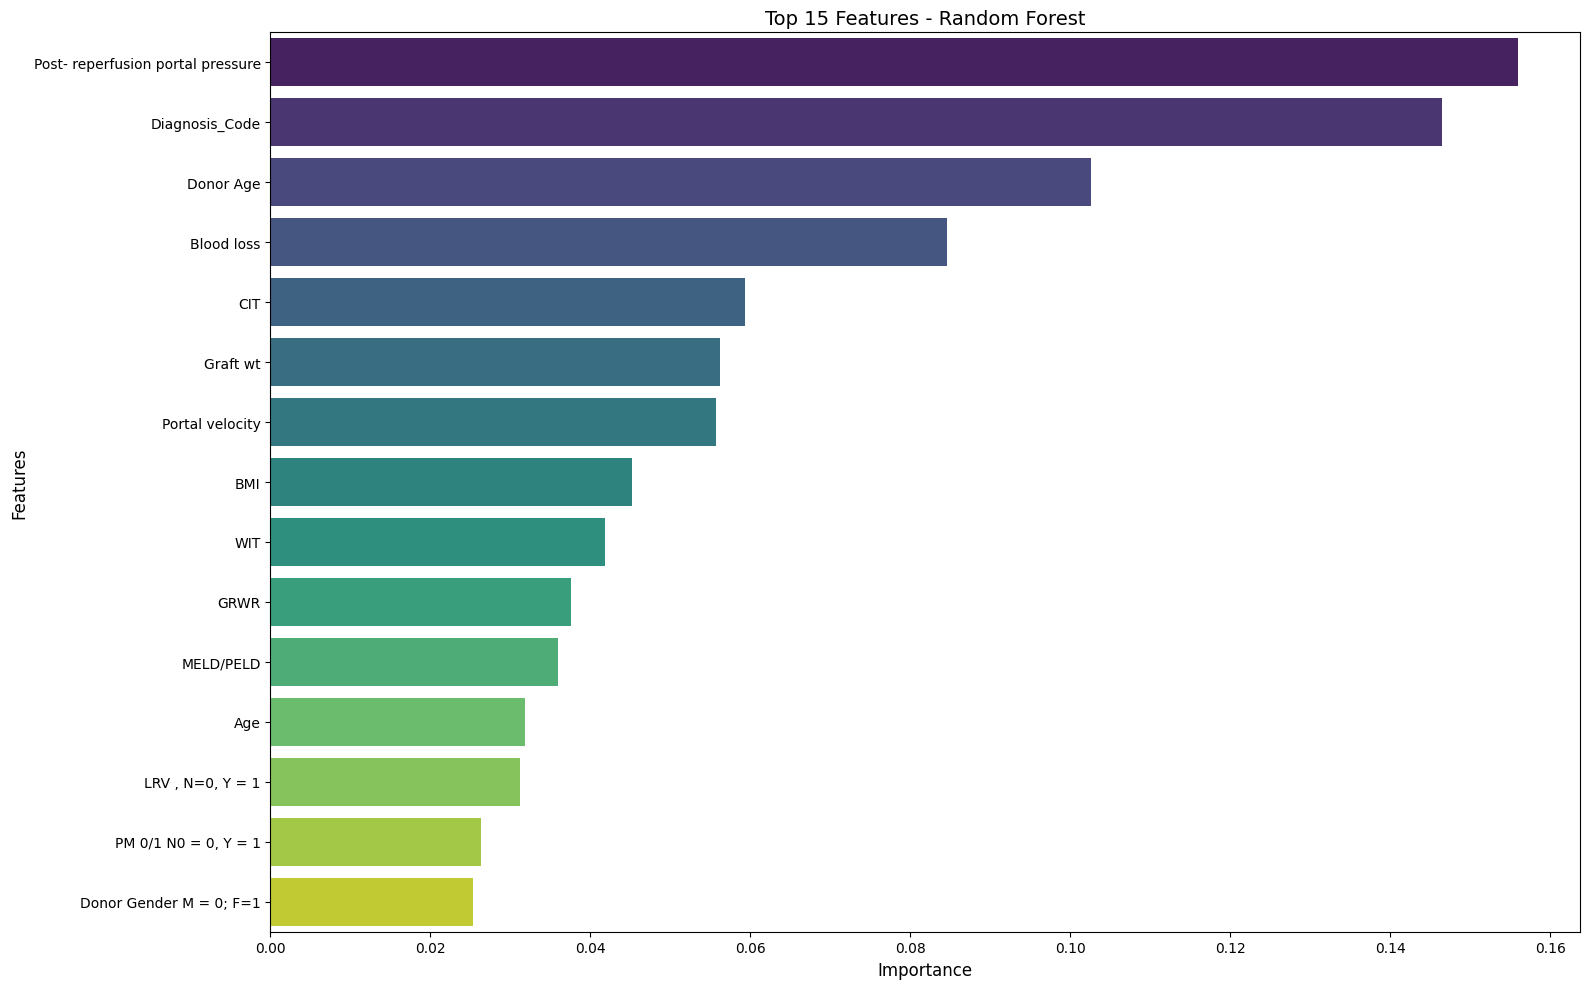

In [32]:
# 1. Train Random Forest on Resampled Data
rf_model = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train_res)  # ✅ Use y_train_res

# 2. Compute Feature Importances
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Print Feature Importances
print("Random Forest Feature Importances (Table):")
print(rf_importances)

# 3. Plot Feature Importances
plot_features(rf_importances, 'Random Forest')


XGBoost Feature Importances (Table):
                              Feature  Importance
2                      Diagnosis_Code    0.161316
16               PM 0/1 N0 = 0, Y = 1    0.122611
17                   SAL N = 0, Y = 1    0.111985
22            Post PM Portal velocity    0.096064
15  Post- reperfusion portal pressure    0.093182
6                           Donor Age    0.059183
18                   LRV , N=0, Y = 1    0.050408
14                    Portal velocity    0.046030
23            post PM portal pressure    0.045047
11                         Blood loss    0.039698
13                                WIT    0.038119
7             Donor Gender M = 0; F=1    0.031579
9                            Graft wt    0.027378
0                                 Age    0.019122
4                           MELD/PELD    0.017608
10                               GRWR    0.014433
12                                CIT    0.014035
3                                 BMI    0.008247
24           

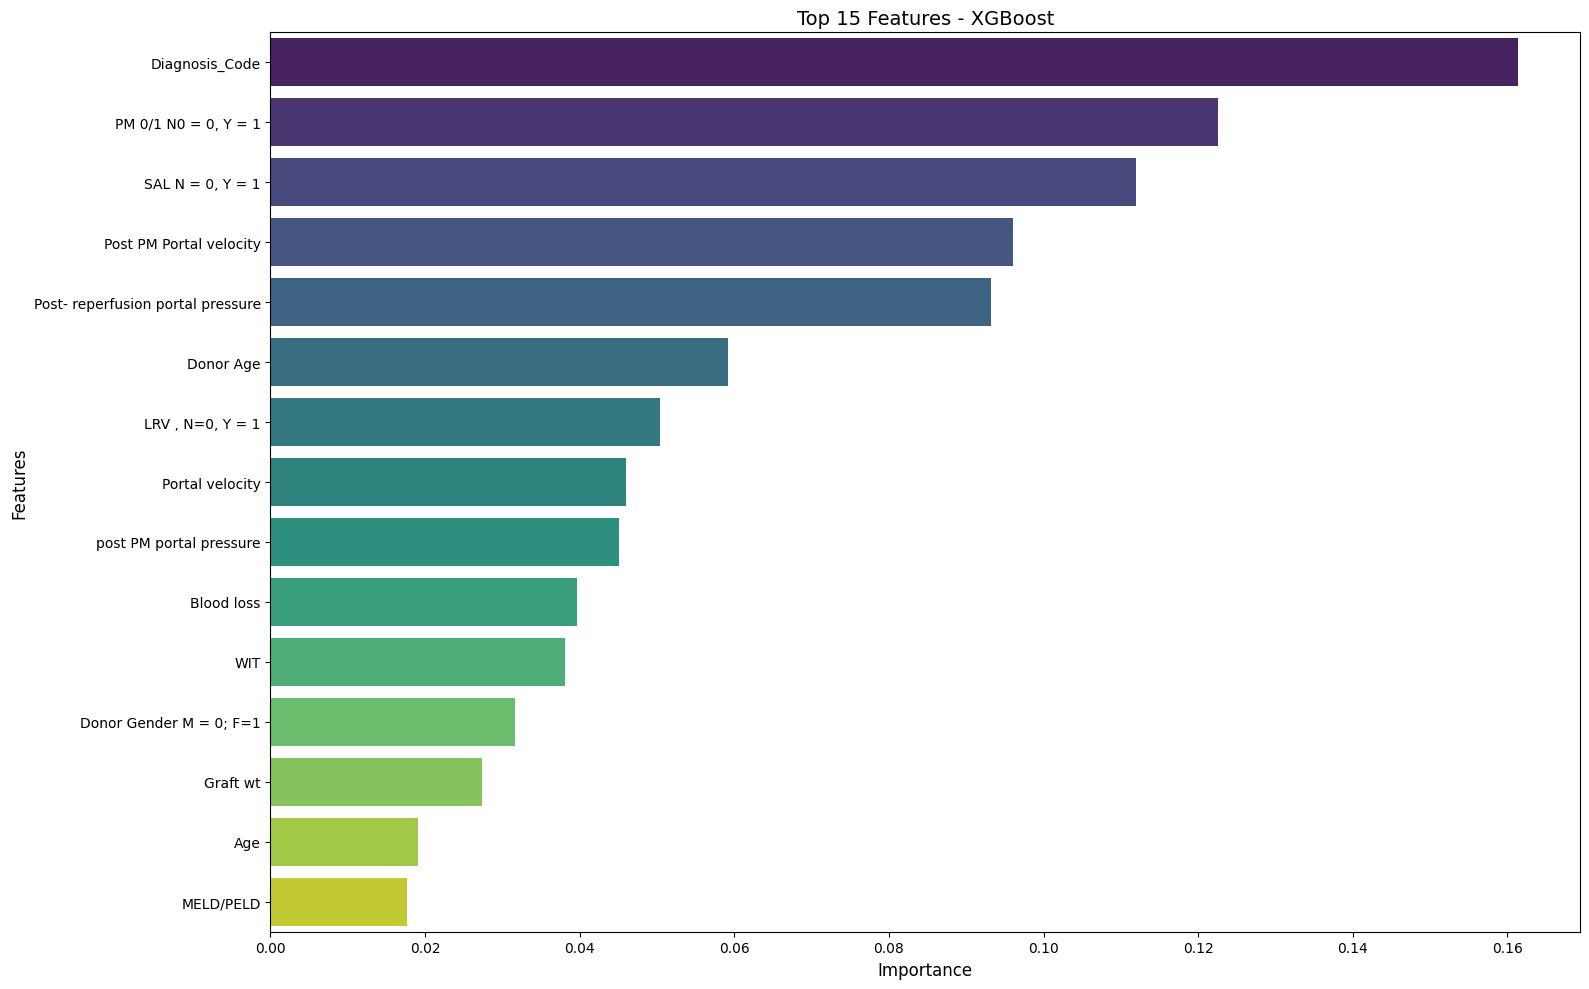

In [35]:
# 2. XGBoost Importance
xgb_model = XGBClassifier(random_state=42).fit(X_train_scaled, y_train_res)
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Print Feature Importances
print("XGBoost Feature Importances (Table):")
print(xgb_importances)

plot_features(xgb_importances, 'XGBoost')

SHAP values shape: (39, 26, 2)
Feature Importance (Mean Absolute SHAP values):
                              Feature  Importance
15  Post- reperfusion portal pressure    0.085344
6                           Donor Age    0.056176
9                            Graft wt    0.049247
2                      Diagnosis_Code    0.045061
3                                 BMI    0.041514
23            post PM portal pressure    0.020909
7             Donor Gender M = 0; F=1    0.018802
12                                CIT    0.017647
11                         Blood loss    0.017567
16               PM 0/1 N0 = 0, Y = 1    0.016038
22            Post PM Portal velocity    0.013359
18                   LRV , N=0, Y = 1    0.013290
0                                 Age    0.012845
25                 Change in Pressure    0.008591
17                   SAL N = 0, Y = 1    0.007809
13                                WIT    0.006722
10                               GRWR    0.003445
14                   

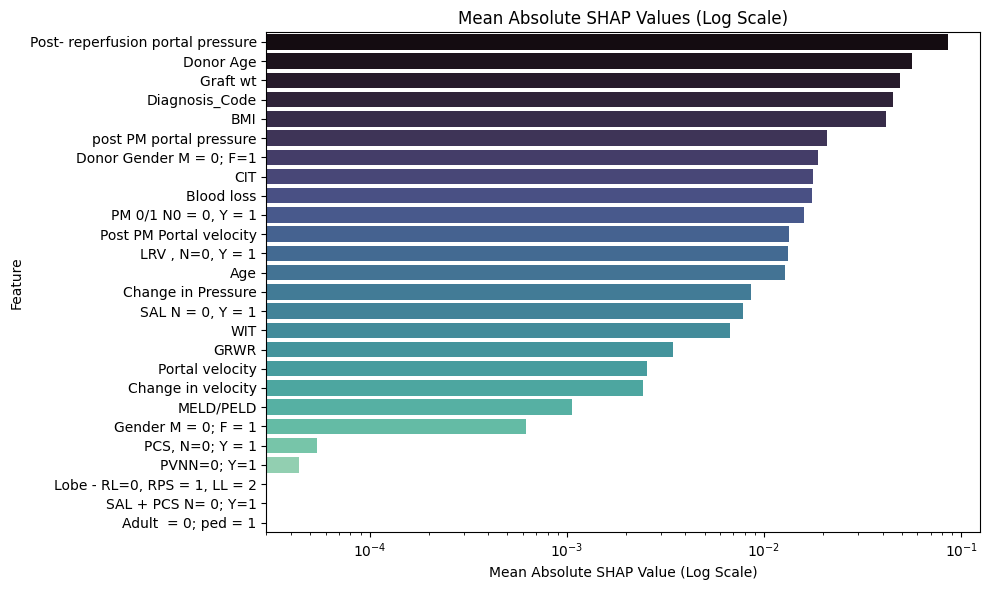

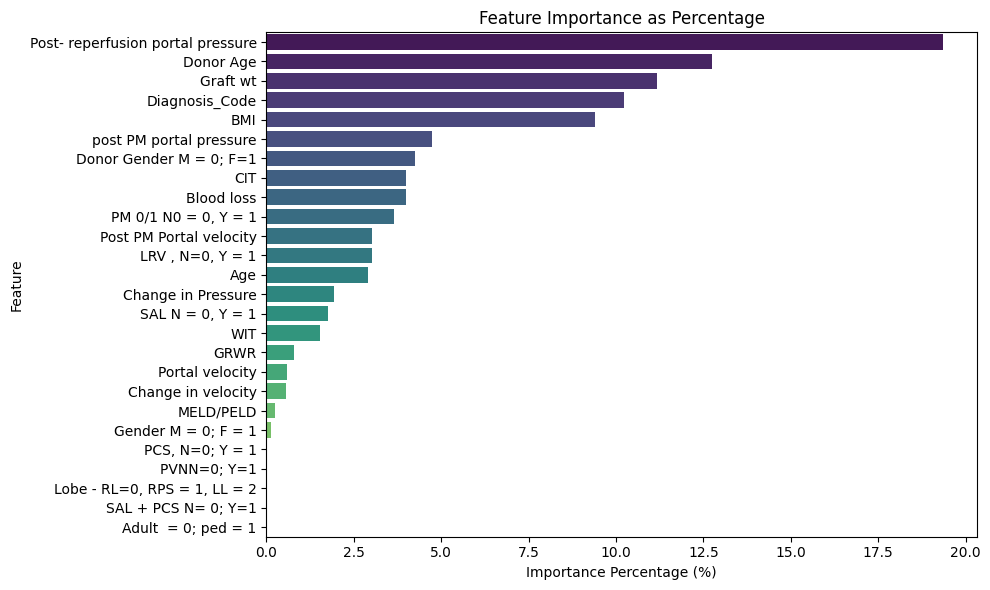

In [36]:
import pandas as pd
import shap

# Ensure X_test_df is a DataFrame with proper column names
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    X_test_df = X_test.copy()

# Create an explainer using the training data (ensure X_train is a DataFrame)
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test_df)

# Print the shape to check dimensions
print("SHAP values shape:", shap_values.values.shape)

# If the shap_values are 3-dimensional, select the positive class (index 1)
if len(shap_values.values.shape) == 3:
    # For binary classification, assume the third dimension has size 2.
    mean_abs_shap = np.abs(shap_values.values[..., 1]).mean(axis=0)
else:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for feature importance
perm_df = pd.DataFrame({
    'Feature': X_test_df.columns,
    'Importance': mean_abs_shap
}).sort_values('Importance', ascending=False)

# Print the mean absolute SHAP values
print("Feature Importance (Mean Absolute SHAP values):")
print(perm_df)

# Normalize the importance values to percentages
total_importance = perm_df['Importance'].sum()
perm_df['Importance Percent'] = 100 * perm_df['Importance'] / total_importance

print("\nFeature Importance as Percentages:")
print(perm_df[['Feature', 'Importance Percent']])

# Plot using a log scale on the x-axis to better show small differences
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df, palette='mako')
plt.xscale('log')  # Log scale
plt.title("Mean Absolute SHAP Values (Log Scale)")
plt.xlabel("Mean Absolute SHAP Value (Log Scale)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Alternatively, plot normalized percentages in a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Percent', y='Feature', data=perm_df, palette='viridis')
plt.title("Feature Importance as Percentage")
plt.xlabel("Importance Percentage (%)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Lasso Regression Feature Importances (Table):
                              Feature  Coefficient
18                   LRV , N=0, Y = 1     0.148547
7             Donor Gender M = 0; F=1    -0.120969
2                      Diagnosis_Code     0.101444
12                                CIT     0.101362
14                    Portal velocity     0.097549
23            post PM portal pressure    -0.097279
17                   SAL N = 0, Y = 1    -0.093995
15  Post- reperfusion portal pressure     0.085007
6                           Donor Age     0.075655
19                    PCS, N=0; Y = 1    -0.072204
10                               GRWR     0.058120
0                                 Age    -0.056956
9                            Graft wt    -0.039085
11                         Blood loss    -0.018397
3                                 BMI    -0.018093
13                                WIT    -0.015389
21                SAL + PCS N= 0; Y=1    -0.012213
1                 Gender M = 0; F = 

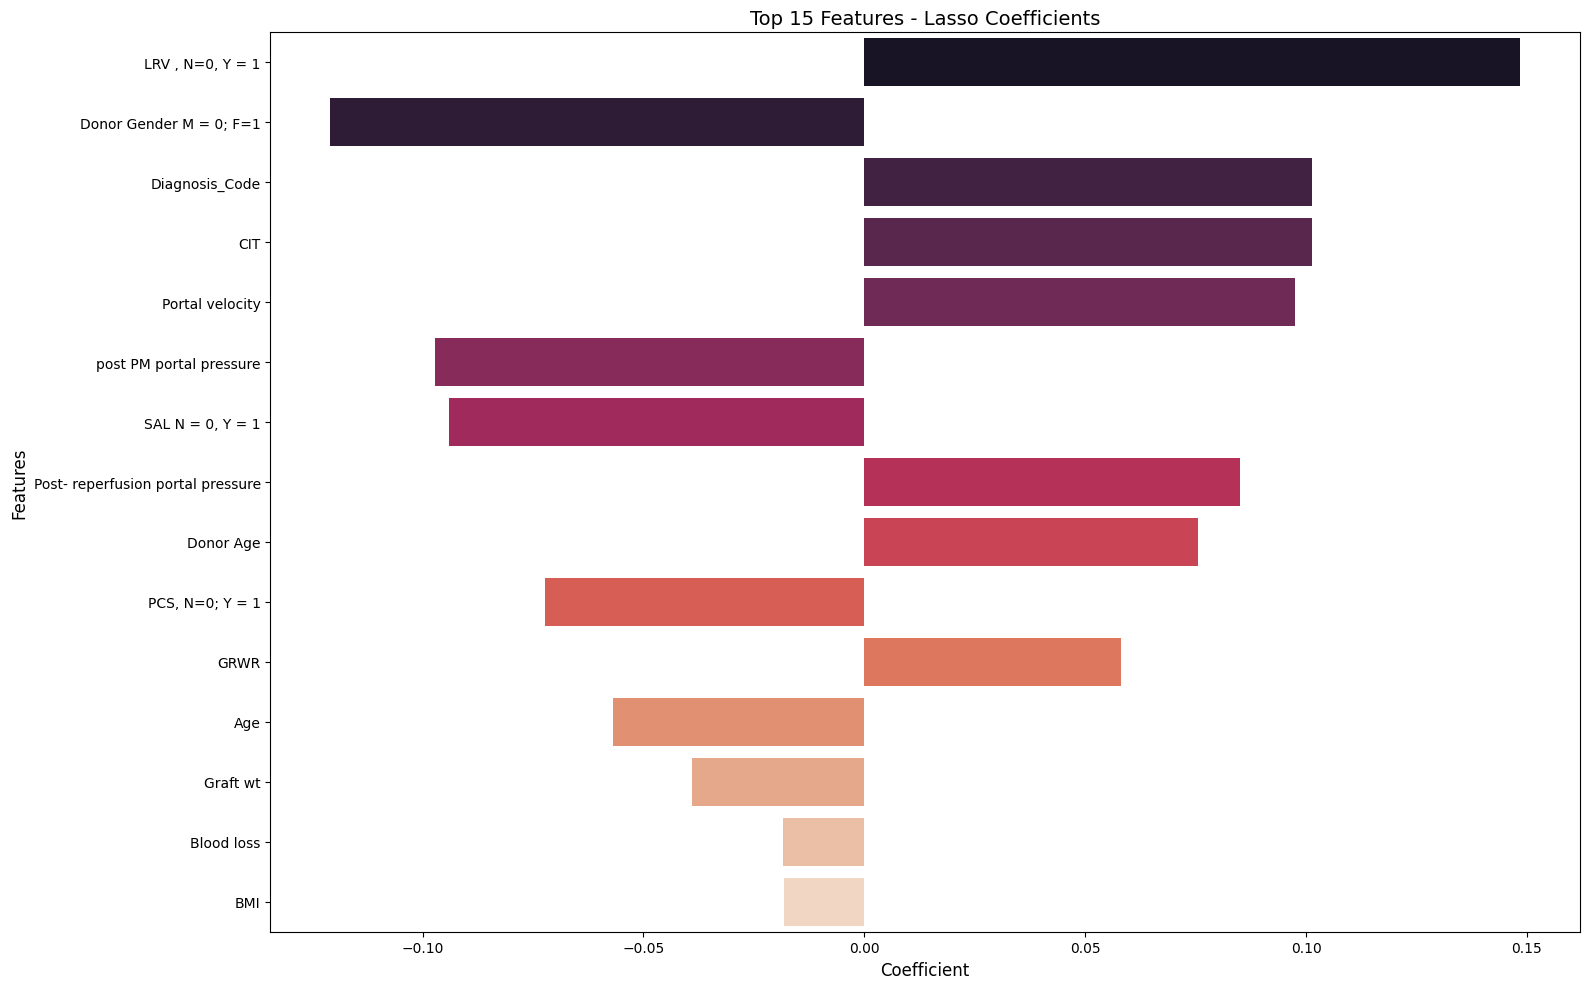

In [38]:
# 4. Lasso Regression
lasso_model = LassoCV(max_iter=10000, random_state=42).fit(X_train_scaled, y_train_res)
lasso_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
}).query('Coefficient != 0').sort_values('Coefficient', key=abs, ascending=False)

# Print Feature Importances
print("Lasso Regression Feature Importances (Table):")
print(lasso_coef)

plot_features(lasso_coef, 'Lasso Coefficients', xlabel='Coefficient', palette='rocket')

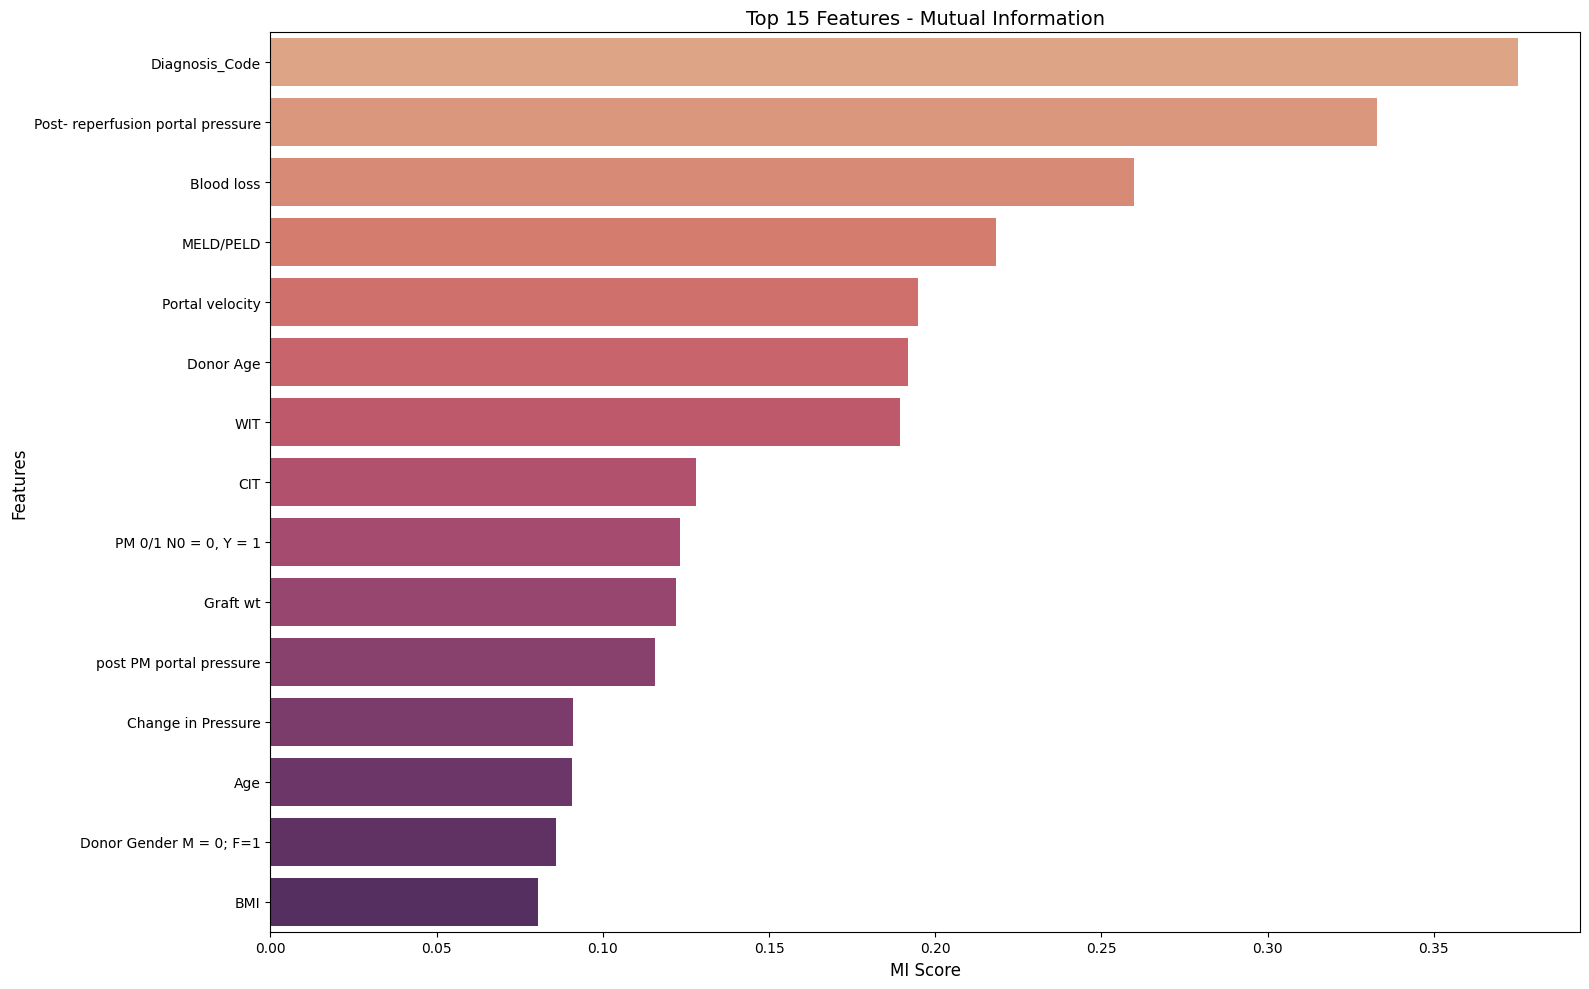

In [39]:
# 5. Mutual Information
mi_scores = mutual_info_classif(X_train_res, y_train_res, random_state=42)
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)
plot_features(mi_df, 'Mutual Information', xlabel='MI Score', palette='flare')


Sequential Forward Selection Features:
('0', '1', '3', '4', '5', '7', '8', '12', '14', '15', '16', '17', '19', '20', '21')
Selected Features: ['Age', 'Gender M = 0; F = 1', 'BMI', 'MELD/PELD', 'Adult  = 0; ped = 1', 'Donor Gender M = 0; F=1', 'Lobe - RL=0, RPS = 1, LL = 2', 'CIT', 'Portal velocity', 'Post- reperfusion portal pressure', 'PM 0/1 N0 = 0, Y = 1', 'SAL N = 0, Y = 1', 'PCS, N=0; Y = 1', 'PVNN=0; Y=1', 'SAL + PCS N= 0; Y=1']

Feature Importance (Sorted):
                              Feature  Importance
0                                 Age    0.235292
1                                 BMI    0.159095
2                                 CIT    0.146244
3                           MELD/PELD    0.129445
4                     Portal velocity    0.126295
5   Post- reperfusion portal pressure    0.093160
6             Donor Gender M = 0; F=1    0.031288
7                 Gender M = 0; F = 1    0.031057
8                PM 0/1 N0 = 0, Y = 1    0.028359
9                    SAL N = 0

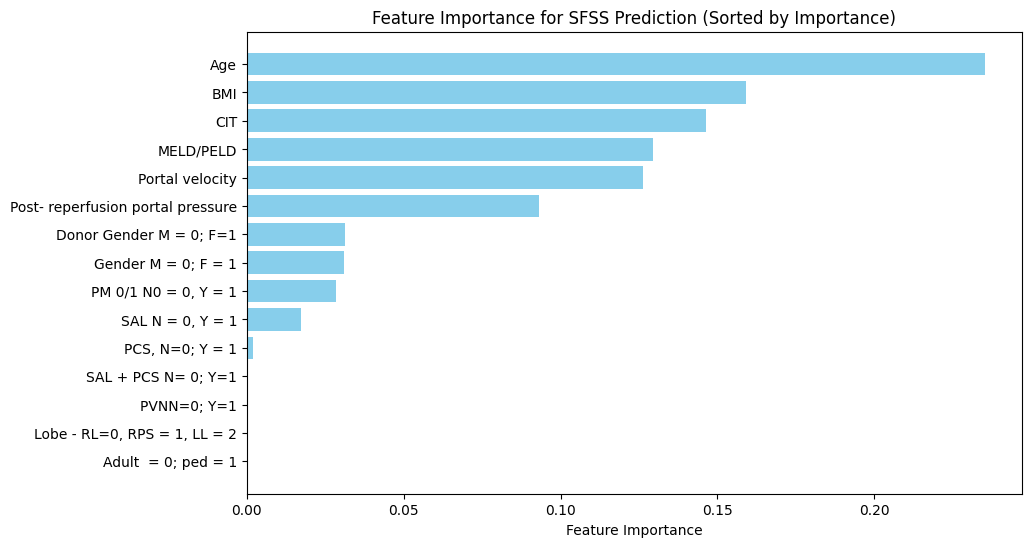

In [24]:
# 6. Sequential Forward Selection
sfs = SFS(RandomForestClassifier(random_state=42),
          k_features=15,
          forward=True,
          cv=5,
          n_jobs=-1).fit(X_train_scaled, y_train)
print("\nSequential Forward Selection Features:")
print(sfs.k_feature_names_)

# Assuming you have the original feature names stored in a list
selected_features = [feature_names[int(i)] for i in sfs.k_feature_names_]

print("Selected Features:", selected_features)

# Fit a random forest classifier to the selected features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled[:, sfs.k_feature_idx_], y_train)

# Get the feature importances
importance = rf_model.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(importance)[::-1]
sorted_features = np.array(selected_features)[sorted_idx]
sorted_importance = importance[sorted_idx]

# Create a DataFrame to display the features and their importances
feature_importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importance
})

# Display the feature importances in a table
print("\nFeature Importance (Sorted):")
print(feature_importance_df)

# Optionally, you can plot this in a bar chart as well
import matplotlib.pyplot as plt

# Plot the feature importance bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for SFSS Prediction (Sorted by Importance)')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()



Sequential Forward Selection Features:
('1', '2', '3', '5', '7', '8', '14', '16', '18', '19', '20', '21', '22', '23', '24')
Selected Features: ['Gender M = 0; F = 1', 'Diagnosis_Code', 'BMI', 'Adult  = 0; ped = 1', 'Donor Gender M = 0; F=1', 'Lobe - RL=0, RPS = 1, LL = 2', 'Portal velocity', 'PM 0/1 N0 = 0, Y = 1', 'LRV , N=0, Y = 1', 'PCS, N=0; Y = 1', 'PVNN=0; Y=1', 'SAL + PCS N= 0; Y=1', 'Post PM Portal velocity', 'post PM portal pressure', 'Change in velocity']

Feature Importance (Sorted):
                         Feature  Importance
0        post PM portal pressure    0.367129
1           PM 0/1 N0 = 0, Y = 1    0.170194
2                 Diagnosis_Code    0.123746
3                Portal velocity    0.109964
4        Donor Gender M = 0; F=1    0.092358
5                            BMI    0.074747
6             Change in velocity    0.061862
7        Post PM Portal velocity    0.000000
8            SAL + PCS N= 0; Y=1    0.000000
9                    PVNN=0; Y=1    0.000000
10  

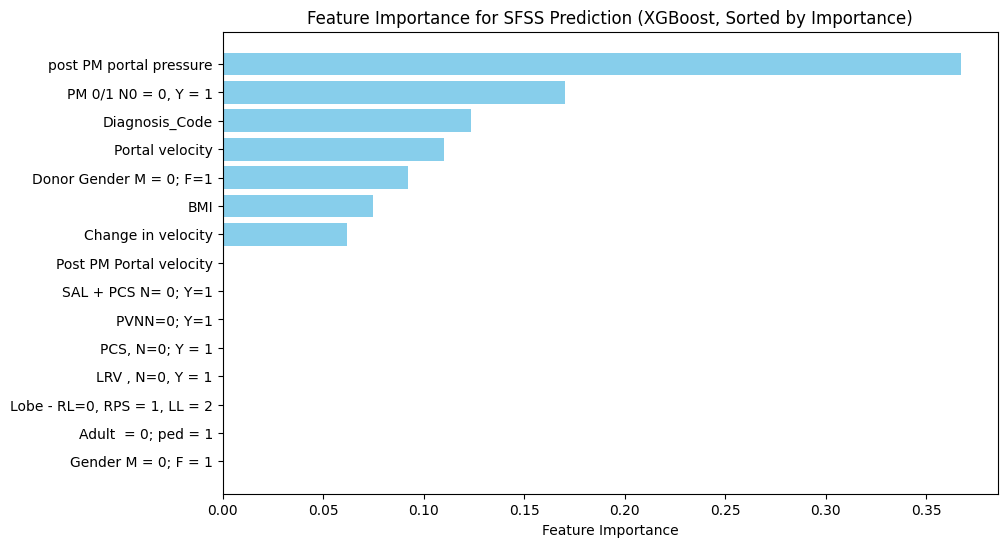

In [25]:
# Use XGBClassifier as the estimator for SFS
sfs = SFS(XGBClassifier(random_state=42),
          k_features=15,
          forward=True,
          cv=5,
          n_jobs=-1).fit(X_train_scaled, y_train)

print("\nSequential Forward Selection Features:")
print(sfs.k_feature_names_)

# Map the selected feature indices (as strings) to their names using feature_names list
selected_features = [feature_names[int(i)] for i in sfs.k_feature_names_]
print("Selected Features:", selected_features)

# Fit an XGBoost classifier to the selected features
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled[:, sfs.k_feature_idx_], y_train)

# Get the feature importances from the trained XGBoost model
importance = xgb_model.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(importance)[::-1]
sorted_features = np.array(selected_features)[sorted_idx]
sorted_importance = importance[sorted_idx]

# Create a DataFrame to display the features and their importances
feature_importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importance
})

# Display the feature importances in a table
print("\nFeature Importance (Sorted):")
print(feature_importance_df)

# Plot the feature importance bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for SFSS Prediction (XGBoost, Sorted by Importance)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

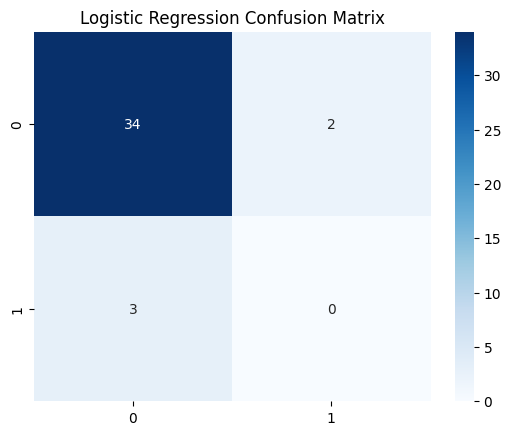

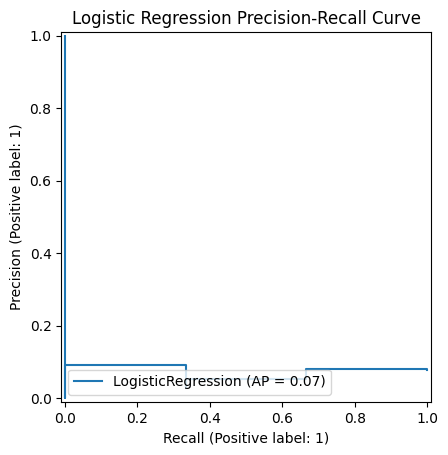

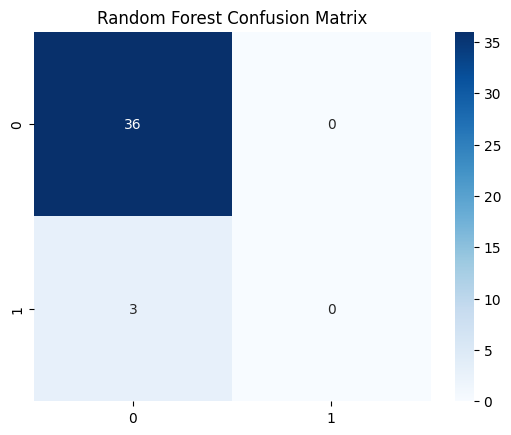

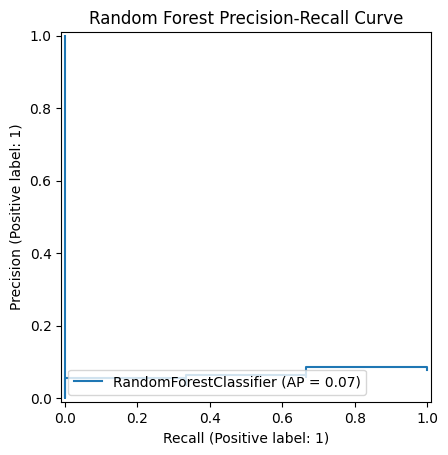

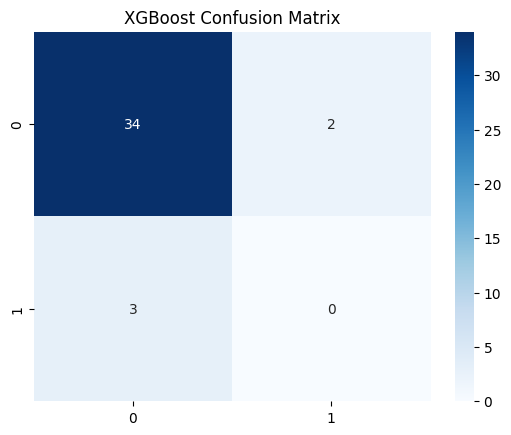

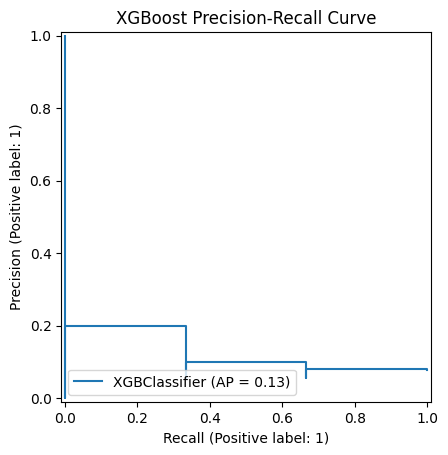

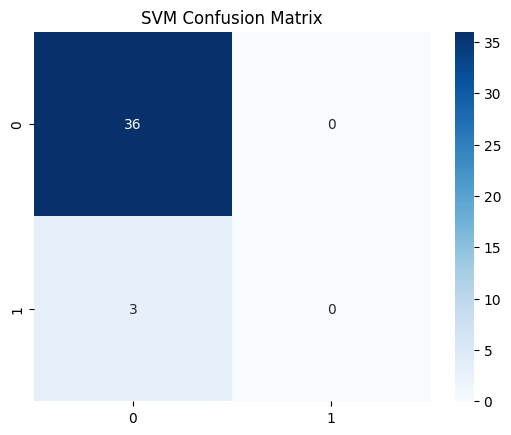

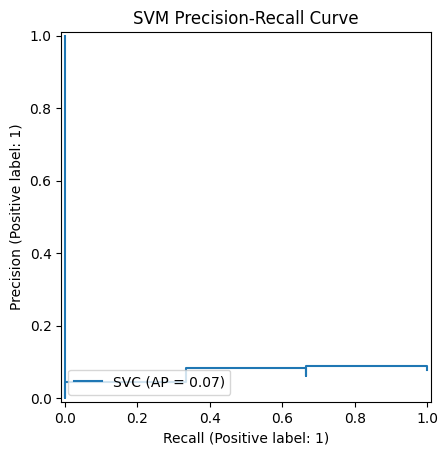


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC AUC,CV Accuracy (Mean)
0,Logistic Regression,0.872,0.0,0.0,0.0,0.259,0.903
1,Random Forest,0.923,0.0,0.0,0.0,0.292,0.909
2,XGBoost,0.872,0.0,0.0,0.0,0.481,0.883
3,SVM,0.923,0.0,0.0,0.0,0.306,0.909


<Figure size 1400x800 with 0 Axes>

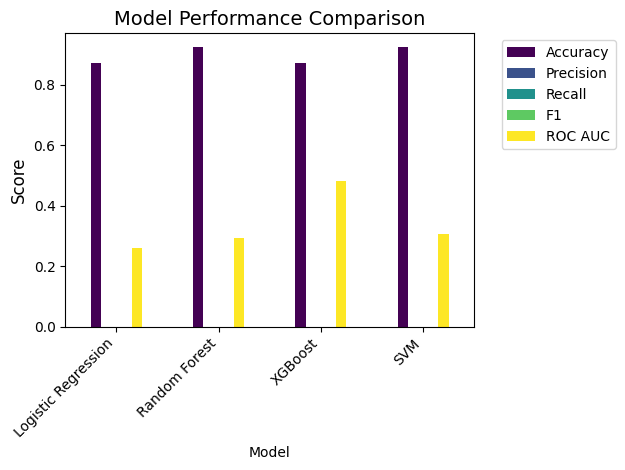

In [26]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42))
]

results = []

for name, model in models:
    # Train the model on the scaled training data
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Use predict_proba if available; otherwise, leave ROC AUC as None
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = None

    # Calculate performance metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'CV Accuracy (Mean)': np.mean(cross_val_score(model, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy'))
    }
    results.append(metrics)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    # Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(f'{name} Precision-Recall Curve')
    plt.show()

# Create and display results DataFrame
results_df = pd.DataFrame(results).round(3)
print("\nModel Performance Comparison:")
display(results_df)

# Visualize the metrics in a bar chart
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
results_df.set_index('Model')[metrics_to_plot].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


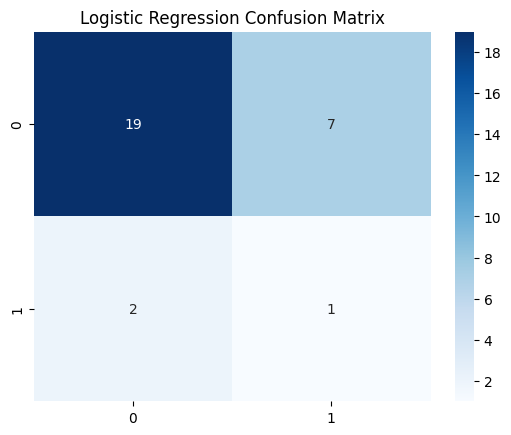

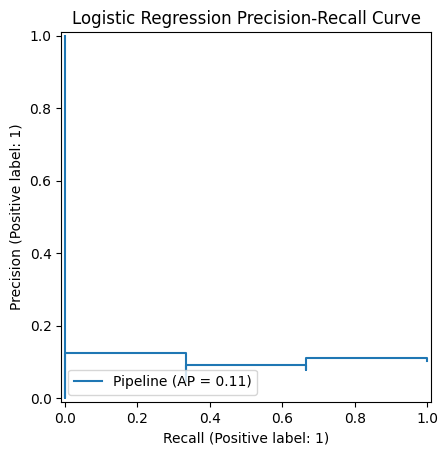

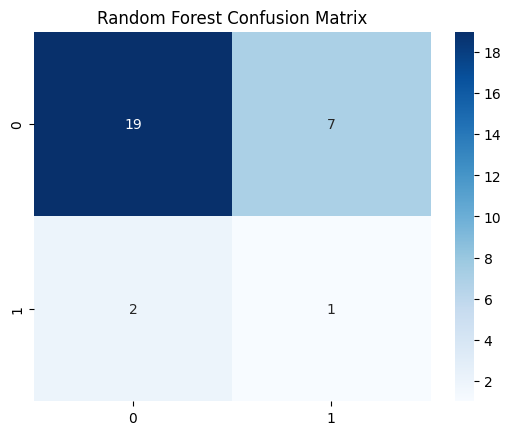

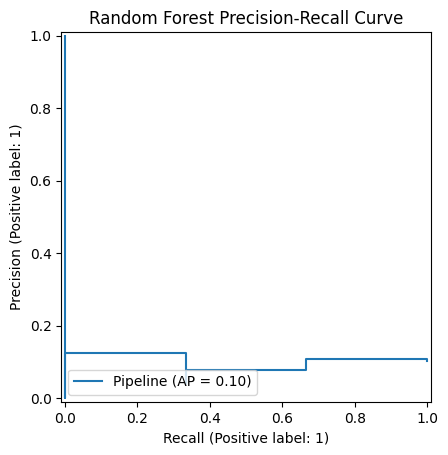

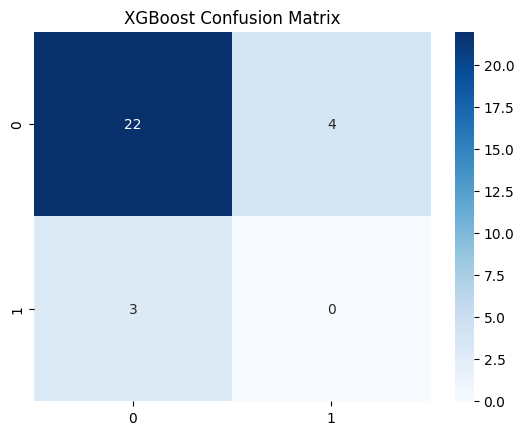

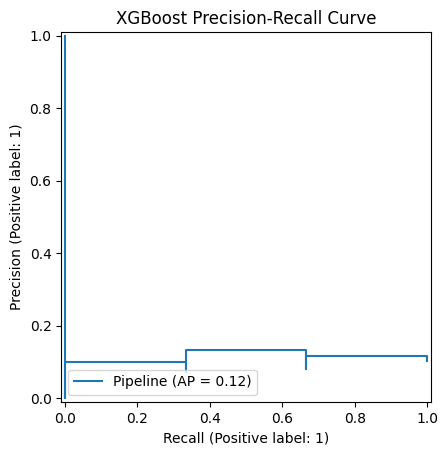

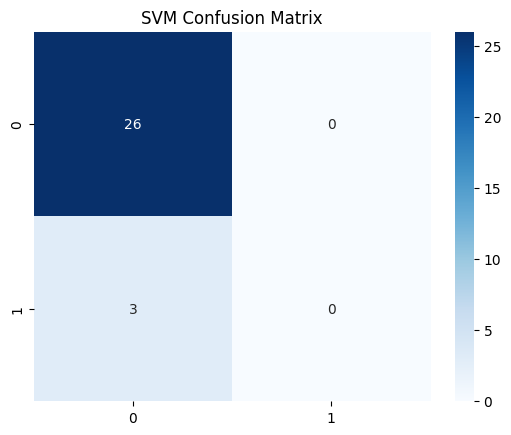

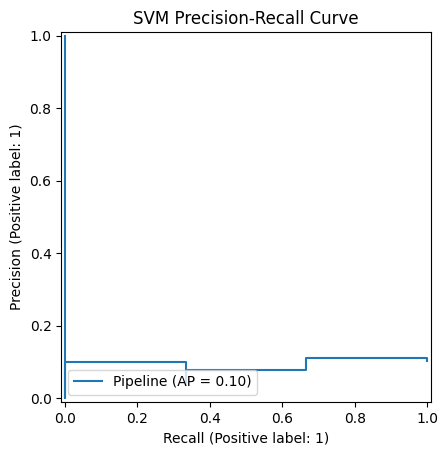


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC AUC  \
0  Logistic Regression  0.689655      0.125  0.333333  0.181818  0.346154   
1        Random Forest  0.689655      0.125  0.333333  0.181818  0.294872   
2              XGBoost  0.758621      0.000  0.000000  0.000000  0.423077   
3                  SVM  0.896552      0.000  0.000000  0.000000  0.269231   

   Optimal Threshold  
0           0.622449  
1           0.230612  
2           0.500000  
3           0.500000  


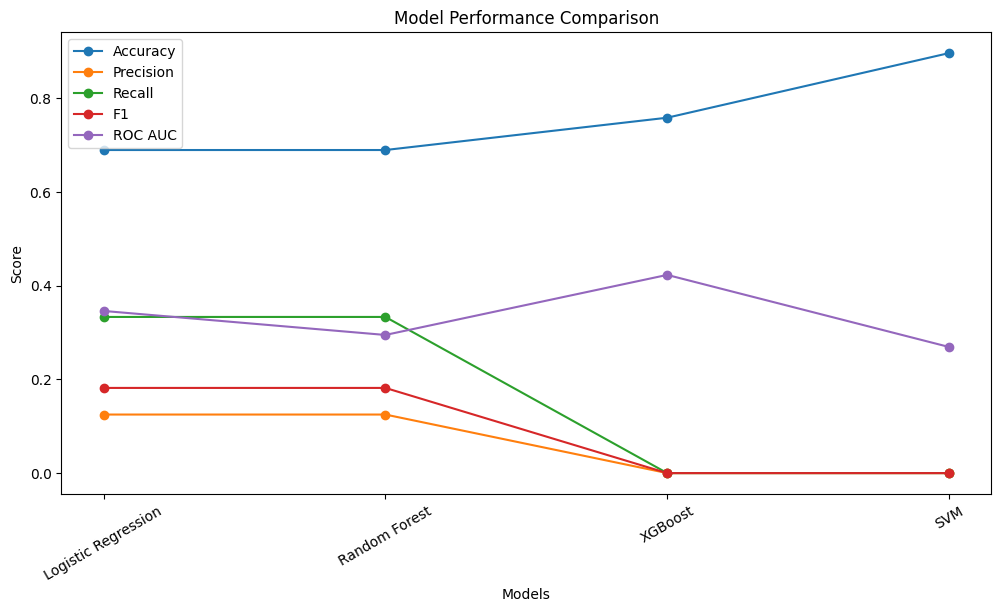

In [85]:
# Store results in a list
results = []
feature_importances = []

for name, model in models:
    # Create pipeline with SMOTE
    pipeline = make_pipeline(smote, model)
    pipeline.fit(X_train_scaled, y_train)
    
    # Threshold optimization
    best_thresh = optimize_threshold(pipeline, X_test_scaled, y_test)
    y_proba = pipeline.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_proba >= best_thresh).astype(int)
    
    # Feature importance storage (only if the model supports it)
    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_,
            'Model': name
        })
        feature_importances.append(feat_imp)
    
    # Metrics calculation
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Optimal Threshold': best_thresh
    }
    results.append(metrics)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    # Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(pipeline, X_test_scaled, y_test)
    plt.title(f'{name} Precision-Recall Curve')
    plt.show()

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot model accuracy comparison
plt.figure(figsize=(12, 6))
metrics_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

for metric in metrics_to_compare:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.xticks(rotation=30)
plt.show()



Final Model Performance:


,Model,Validation Accuracy,Test Accuracy,Validation F1,Test F1,Validation ROC AUC,Test ROC AUC,Optimal Threshold
0,Logistic Regression,0.448,0.345,0.200,0.095,0.397,0.444,0.133
1,Random Forest,0.897,0.793,0.571,0.000,0.769,0.472,0.361
2,XGBoost,0.793,0.690,0.400,0.000,0.795,0.278,0.100
3,SVM,0.897,0.931,0.400,0.000,0.615,0.352,0.557



Feature Stability Analysis:


,Model,Stability Score
0,Random Forest,NaN
1,XGBoost,-0.684


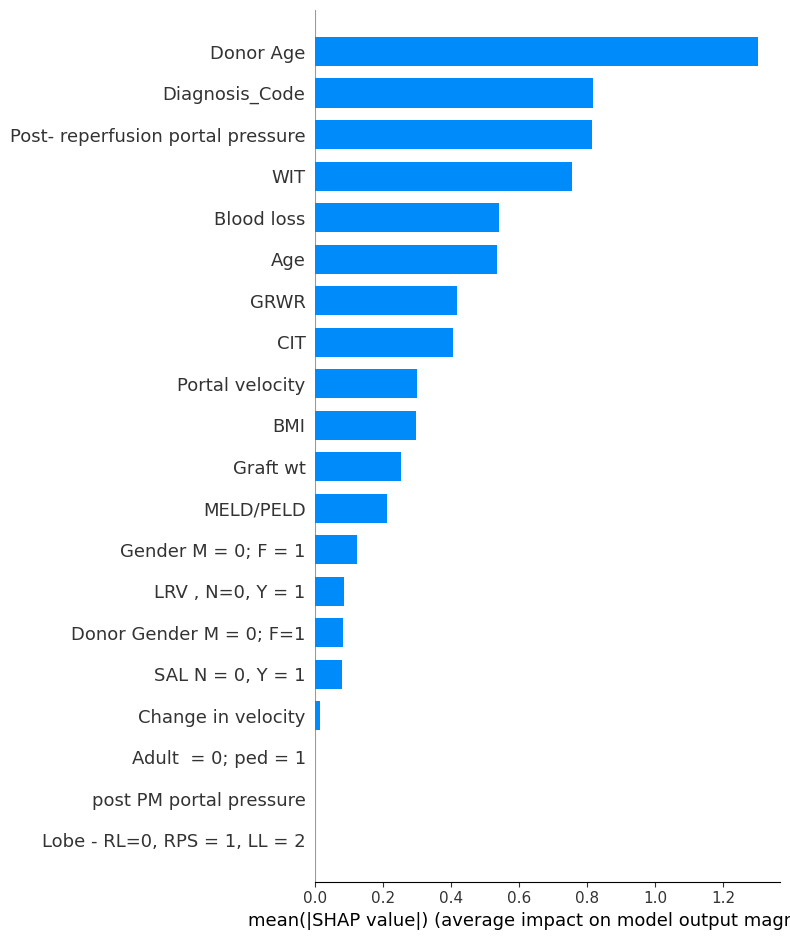

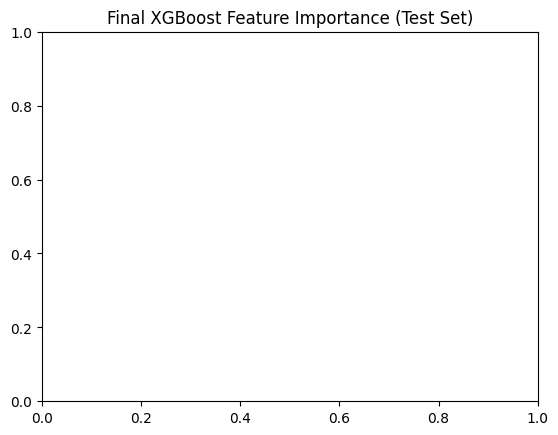

In [28]:
# %% [code] - Data Splitting with Validation Set
# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Scaling with validation set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# %% [code] - Enhanced Model Evaluation with Validation
def evaluate_model(model, X_train, y_train, X_val, X_test):
    """Train model and return validation/test metrics"""
    # Train with SMOTE only on training data
    pipeline = make_pipeline(
        SMOTE(random_state=42),
        model
    )
    pipeline.fit(X_train, y_train)
    
    # Threshold optimization using validation set
    best_thresh = optimize_threshold(pipeline, X_val, y_val)
    
    # Predictions
    val_proba = pipeline.predict_proba(X_val)[:, 1]
    test_proba = pipeline.predict_proba(X_test)[:, 1]
    
    val_pred = (val_proba >= best_thresh).astype(int)
    test_pred = (test_proba >= best_thresh).astype(int)
    
    return {
        'Validation Accuracy': accuracy_score(y_val, val_pred),
        'Validation F1': f1_score(y_val, val_pred),
        'Validation ROC AUC': roc_auc_score(y_val, val_proba),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Test F1': f1_score(y_test, test_pred),
        'Test ROC AUC': roc_auc_score(y_test, test_proba),
        'Optimal Threshold': best_thresh
    }

# %% [code] - Model Configuration with Class Weights
models = [
    ('Logistic Regression', LogisticRegression(
        class_weight='balanced', 
        random_state=42,
        max_iter=1000
    )),
    ('Random Forest', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    )),
    ('XGBoost', XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        eval_metric='logloss',
        random_state=42
    )),
    ('SVM', SVC(
        class_weight='balanced',
        probability=True,
        random_state=42
    ))
]

# %% [code] - Comprehensive Evaluation
results = []
for name, model in models:
    metrics = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, X_test_scaled)
    metrics['Model'] = name
    results.append(metrics)
    
results_df = pd.DataFrame(results).round(3)
cols_order = ['Model', 'Validation Accuracy', 'Test Accuracy', 
              'Validation F1', 'Test F1', 'Validation ROC AUC', 
              'Test ROC AUC', 'Optimal Threshold']
print("\nFinal Model Performance:")
display(results_df[cols_order])

# %% [code] - Feature Stability Analysis
def check_feature_stability(models, feature_names):
    """Analyze feature importance consistency across train/val/test"""
    stability_scores = []
    
    for name, model in models:
        # Train on full training set
        model.fit(X_train_scaled, y_train)
        
        # Get importances
        if hasattr(model, 'feature_importances_'):
            train_imp = model.feature_importances_
            
            # Calculate validation importance using permutation
            val_imp = permutation_importance(
                model, X_val_scaled, y_val,
                n_repeats=10,
                random_state=42
            ).importances_mean
            
            # Stability score (cosine similarity)
            stability = np.dot(train_imp, val_imp) / (
                np.linalg.norm(train_imp) * np.linalg.norm(val_imp)
            )
            
            stability_scores.append({
                'Model': name,
                'Stability Score': round(stability, 3)
            })
            
    return pd.DataFrame(stability_scores)

print("\nFeature Stability Analysis:")
display(check_feature_stability(models, feature_names))

# %% [code] - Final SHAP Analysis on Test Set
# Best performing model (XGBoost)
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42
).fit(X_train_scaled, y_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, 
                 feature_names=feature_names,
                 plot_type='bar')
plt.title('Final XGBoost Feature Importance (Test Set)')
plt.show()